In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Image Gradients

Image gradient is defined as a directional change in image intensity.

Image gradient applications

1. Detecting edges in images, which allows us to find contours and outlines of objects in images
2. Inputs for quantifying images through feature extraction
3. Construct saliency maps

**Edge detection**

The process of finding edges in an image, which reveals structural information regarding the objects in an image **(edge map)**

Normally you would be computing the orientation and magnitude on a grayscale image where the valid range of values would be [0, 255].

Edges could therefore correspond to

1. Boundaries of an object in an image
2. Boundaries of shadowing or lighting conditions in an image
3. Boundaries of "parts" within an object

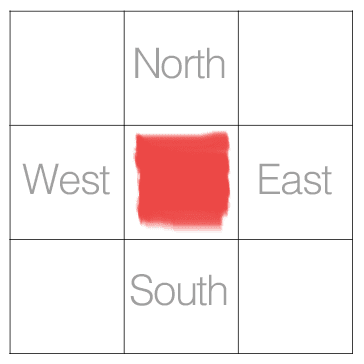

If we denote our input image as $I$, then we define the north, south, east, and west pixels using the following notation:

- North : $I(x, y - 1)$
- South : $I(x, y + 1)$
- East : $I(x + 1, y)$
- West : $I(x - 1, y)$

- Vertical change or the y-change by taking the difference between the south and north

    $G_y = I(x, y + 1) – I(x, y − 1)$


- Horizontal change or the x-change by taking the difference between the east and west pixels

    $G_x = I(x + 1, y) – I(x − 1, y)$

We’ll need to define two new terms

- **Gradient magnitude**: measure how strong the change in image intensity is
- **Gradient orientation**: determine in which direction the change in intensity is pointing


By estimating the direction or orientation along with the magnitude (i.e. how strong the change in direction is), we are able to detect regions of an image that look like edges.

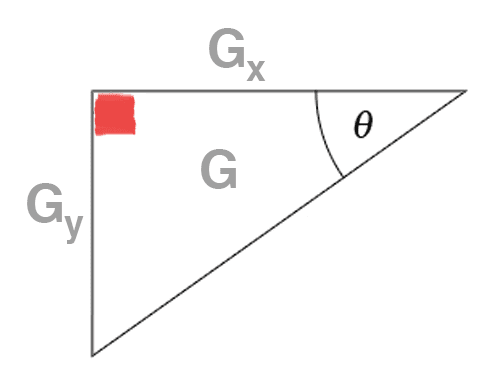

Using both $G_x$ and $G_y$, we can apply some basic trigonometry to compute the gradient magnitude G, and orientation

$G = \sqrt{G_{x}^{2} + G_{y}^{2}}$

$\theta = \text{arctan2}(G_{y}, G_{x}) \times \left(\displaystyle\frac{180}{\pi}\right)$

Examples

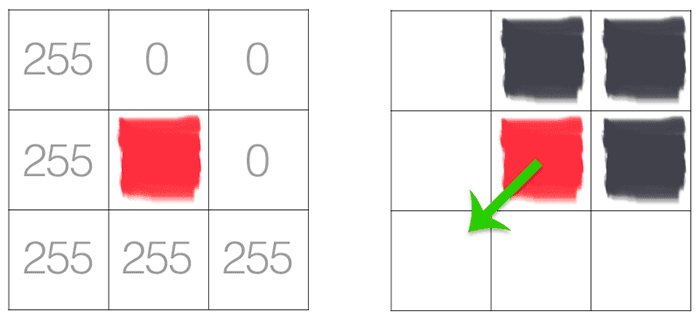

$G_x = 0 − 255 = −255$ and $G_y = 255 − 0 = 255$

$G = \sqrt{(-255)^{2} + 255^{2}} = 360.62$

$\theta = \text{arctan2}(255, -255) \times \left(\displaystyle\frac{180}{\pi}\right) = 135^{\circ}$

**Sobel kernels**

We can approximate gradients using kernels, which will give us a tremendous boost in speed.

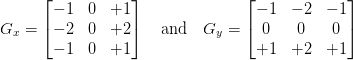

**Scharr kernels**

Scharr kernel could lead to better approximations are heavily rooted in mathematical details

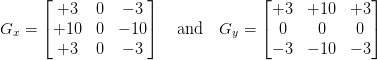

In [61]:
def edge_detection(img: np.array, ksize=-1):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    g_x = cv2.Sobel(img_gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
    g_y = cv2.Sobel(img_gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

    g_x = cv2.convertScaleAbs(g_x)
    g_y = cv2.convertScaleAbs(g_y)

    g = cv2.addWeighted(g_x, 0.5, g_y, 0.5, 0)

    magnitude = np.sqrt((g_x ** 2) + (g_y ** 2))
    orientation = np.arctan2(g_y, g_x) * (180 / np.pi) % 180

    kernel = "Sobel" if ksize > 0 else "Scharr"

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(g, cmap="gray")
    axes[0].set_title(f"{kernel} kernel")

    axes[1].imshow(magnitude, cmap="jet")
    axes[1].set_title("Gradient Magnitude")

    axes[2].imshow(orientation, cmap="jet")
    axes[2].set_title("Gradient Orientation")

    plt.show()

In [2]:
img = cv2.imread("./images/apple.jpg", cv2.IMREAD_UNCHANGED)

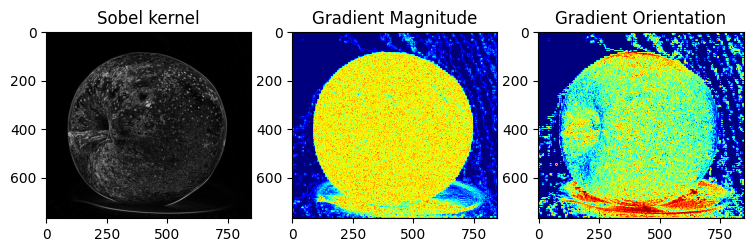

In [63]:
img_edge_sobel = edge_detection(img, ksize=3)

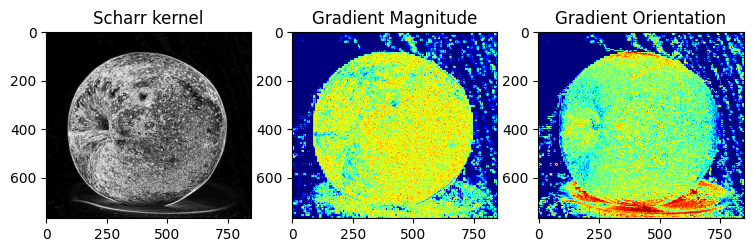

In [64]:
img_edge_scharr = edge_detection(img, ksize=-1)

### Canny Edge Detector

The Canny edge detector is a multi-step algorithm used to detect a wide range of edges in images.

Types of edges there are in images:
1. Step edge
2. Ramp edge
3. Ridge edge
4. Roof edge

Canny edge detection in a nutshell
1. Applying Gaussian smoothing to the image to help reduce noise
2. Computing the $G_{x}$ and $G_{y}$ image gradients using the Sobel kernel
3. Applying non-maxima suppression to keep only the local maxima of gradient magnitude pixels that are pointing in the direction of the gradient **(edge thinning)**
4. Defining and applying the $T_\text{upper}$ and $T_\text{lower}$ thresholds for Hysteresis thresholding

In [66]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [68]:
img_blur = cv2.GaussianBlur(img_gray, (5, 5), 0)

In [74]:
thresholds = [(10, 200), (30, 150), (240, 250)]

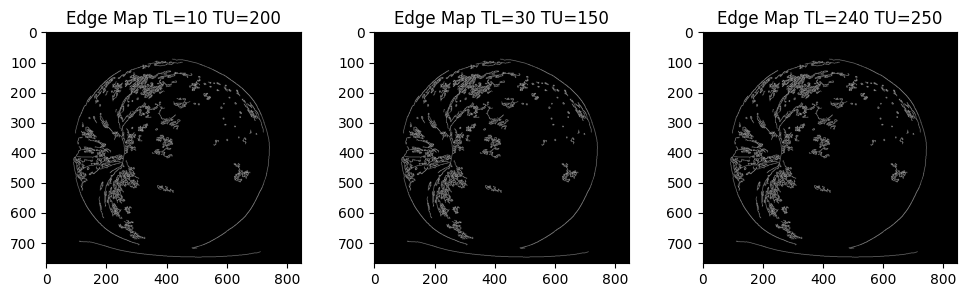

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for idx, (t_lower, t_upper) in enumerate(thresholds):
    img_canny = cv2.Canny(img_blur, 10, 200)

    axes[idx].imshow(img_canny, cmap="gray")
    axes[idx].set_title(f"Edge Map TL={t_lower} TU={t_upper}")

plt.show()

### Hough Transform

Hough transform is a feature extraction method for detecting simple shapes such as circles, lines etc in an image

- A line can be represented by two parameters (slope, intercept)
- A circle has three parameters — the coordinates of the center and the radius (x, y, r)

**Hough transform to detect lines**

The polar form of a line is represented as 

$\rho = x\cos(\theta) + y\sin (\theta)$

Imagine a 2D array where the x-axis has all possible $\theta$ values and the y-axis has all possible $\rho$ values.

Any bin $(\rho, \theta)$ in this 2D array corresponds to one line. This 2D array is called an **accumulator**

The following steps are performed to detect lines in an image

1. Initialize Accumulator
2. Detect Edges
3. Voting by Edge Pixels

In [145]:
img = cv2.imread("./images/road.jpg", cv2.IMREAD_UNCHANGED)

In [147]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [150]:
img_canny = cv2.Canny(img_gray, 180, 240)

In [151]:
lines = cv2.HoughLinesP(img_canny, 1, np.pi / 180, 150, minLineLength=10, maxLineGap=250)

In [146]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [152]:
img_annotate = img_rgb.copy()

In [153]:
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(img_annotate, (x1, y1), (x2, y2), (255, 0, 0), 3)

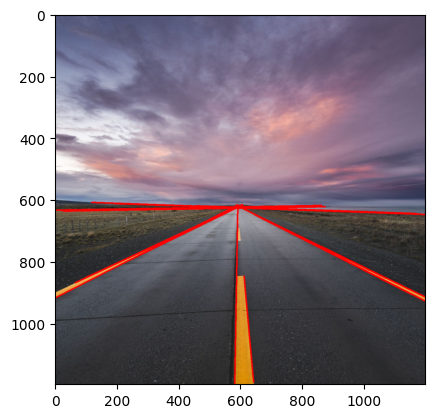

In [155]:
plt.imshow(img_annotate)
plt.show()

### References

- https://pyimagesearch.com/2021/05/12/image-gradients-with-opencv-sobel-and-scharr/
- https://pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/
- https://learnopencv.com/hough-transform-with-opencv-c-python/